In [1]:
from IPython.display import clear_output

!apt-get -y install graphviz graphviz-dev
!pip install tensorflow==2.8 tensorflow-io==0.25.0 tfds-nightly pygraphviz
!pip install tensorflow_gnn==0.2.0
!pip install httplib2==0.20.4

clear_output()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pygraphviz as pgv
from tqdm import tqdm
from IPython.display import Image

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import tensorflow_gnn as tfgnn
import tensorflow_datasets as tfds

from tensorflow_gnn import runner
from tensorflow_gnn.models import gat_v2

print(f'Using TensorFlow v{tf.__version__} and TensorFlow-GNN v{tfgnn.__version__}')
print(f'GPUs available: {tf.config.list_physical_devices("GPU")}')

Using TensorFlow v2.8.0 and TensorFlow-GNN v0.2.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import numpy as np

filepath = "/content/drive/MyDrive/alphafold_results/"
files = [filepath+i for i in os.listdir("/content/drive/MyDrive/alphafold_results/") if i[-4:] == ".npy"]
files

['/content/drive/MyDrive/alphafold_results/test_a0fc1_unrelaxed_rank_1_model_1_out.npy',
 '/content/drive/MyDrive/alphafold_results/test_08cf8_unrelaxed_rank_1_model_1_out.npy',
 '/content/drive/MyDrive/alphafold_results/test_9489e_unrelaxed_rank_1_model_1_out.npy',
 '/content/drive/MyDrive/alphafold_results/test_76590_unrelaxed_rank_1_model_1_out.npy',
 '/content/drive/MyDrive/alphafold_results/test_bb5df_unrelaxed_rank_1_model_1_out.npy',
 '/content/drive/MyDrive/alphafold_results/test_89a16_unrelaxed_rank_1_model_1_out.npy',
 '/content/drive/MyDrive/alphafold_results/test_f7da8_unrelaxed_rank_1_model_1_out.npy',
 '/content/drive/MyDrive/alphafold_results/test_85408_unrelaxed_rank_1_model_1_out.npy',
 '/content/drive/MyDrive/alphafold_results/test_e7dac_unrelaxed_rank_1_model_1_out.npy',
 '/content/drive/MyDrive/alphafold_results/test_93b58_unrelaxed_rank_1_model_1_out.npy',
 '/content/drive/MyDrive/alphafold_results/test_342b4_unrelaxed_rank_1_model_1_out.npy',
 '/content/drive/MyDr

## Preprocessing


In [3]:
def read_data(filename):

    data = np.load(filename, allow_pickle = True)
    df = data.item()

    mydata = {}
    mydata["active"] = tf.convert_to_tensor(np.array([1, 0]), dtype= 'int64')
    mydata["atom_mask"] = tf.convert_to_tensor(np.ones((len(df["features_degree"]),)), dtype = "float32")
    mydata["atoms"] = tf.convert_to_tensor(np.array(list(df["features_degree"].values()), dtype = "float32").reshape((-1, 1)), dtype = "float32")
    mydata["molecule_id"] = tf.convert_to_tensor("id1")
    p_p = np.zeros((len(df["features_degree"]), len(df["features_degree"]), 1))
    for i in df['bond_length']:
        p_p[int(i.split("_")[0]), int(i.split("_")[1])] = [df['bond_length'][i]]
    mydata["pair_mask"] =  tf.convert_to_tensor((p_p>0).reshape((len(df["features_degree"]), len(df["features_degree"]))), dtype = "float32")

    mydata["pairs"] = tf.convert_to_tensor(p_p, dtype= "float32")
    mydata["target"] = tf.convert_to_tensor(df["target"], dtype= "float32")

    return mydata

# dataset_dict = [read_data(i) for i in files]

mydata1 = [read_data(files[0])]


In [4]:
## make tensorflow dataset
import pandas as pd

mydata1 = [read_data(files[0])]
dataset = tf.data.Dataset.from_tensor_slices(pd.DataFrame.from_dict(mydata1).to_dict(orient="list"))

for i in range(1, 64):
    print(i, end = " ")
    tem_data = [read_data(files[i])]
    temp = tf.data.Dataset.from_tensor_slices(pd.DataFrame.from_dict(tem_data).to_dict(orient="list"))
    dataset = dataset.concatenate(temp)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

In [5]:
# ## make tensorflow dataset
# import pandas as pd

# mydata1 = [read_data(files[64])]
# dataset_B = tf.data.Dataset.from_tensor_slices(pd.DataFrame.from_dict(mydata1).to_dict(orient="list"))

# for i in range(65, 100):
#     print(i, end = " ")
#     tem_data = [read_data(files[i])]
#     temp = tf.data.Dataset.from_tensor_slices(pd.DataFrame.from_dict(tem_data).to_dict(orient="list"))
#     dataset_B = dataset_B.concatenate(temp)

In [ ]:
# import gc

# dataset = dataset_A.concatenate(dataset_B)

# gc.collect()
# del dataset_A
# del dataset_B

123

In [6]:
for i in dataset.take(2):
    print(i)

{'active': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>, 'atom_mask': <tf.Tensor: shape=(5417,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, 'atoms': <tf.Tensor: shape=(5417, 1), dtype=float32, numpy=
array([[3.],
       [3.],
       [1.],
       ...,
       [1.],
       [2.],
       [1.]], dtype=float32)>, 'molecule_id': <tf.Tensor: shape=(), dtype=string, numpy=b'id1'>, 'pair_mask': <tf.Tensor: shape=(5417, 5417), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>, 'pairs': <tf.Tensor: shape=(5417, 5417, 1), dtype=float32, numpy=
array([[[0.       ],
        [0.       ],
        [0.       ],
        ...,
        [0.       ],
        [0.       ],
        [0.       ]],

       [[1.5260504],
        [0.       ],
       

In [ ]:
# import pandas as pd
# pd.DataFrame.from_dict(mydata).to_dict(orient="list")

In [7]:

graph_schema_pbtxt = """
node_sets {
  key: "atom"
  value {
    description: "An atom in the molecule."

    features {
      key: "atom_features"
      value: {
        description: "[DATA] The features of the atom."
        dtype: DT_FLOAT
        shape { dim { size: 1 } }
      }
    }
  }
}

edge_sets {
  key: "bond"
  value {
    description: "A bond between two atoms in the molecule."
    source: "atom"
    target: "atom"

    features {
      key: "bond_features"
      value: {
        description: "[DATA] The features of the bond."
        dtype: DT_FLOAT
        shape { dim { size: 1 } }
      }
    }
  }
}

context {
  features {
    key: "stability"
    value: {
      description: "[LABEL] The toxicity class of the molecule (0 -> non-toxic; 1 -> toxic)."
      dtype: DT_FLOAT
    }
  }
  
  features {
    key: "molecule_id"
    value: {
      description: "[LABEL] The id of the molecule."
      dtype: DT_STRING
    }
  }
}
"""

In [ ]:
# for i in dataset.take(4):
#     print(i)

In [8]:

graph_schema = tfgnn.parse_schema(graph_schema_pbtxt)
graph_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema)

In [9]:

def make_graph_tensor(datapoint):
    """
    Convert a datapoint into a `GraphTensor`.
    """
    # atom_mask is non-zero only for real atoms
    # [ V, ]
    atom_indices = tf.squeeze(tf.where(datapoint['atom_mask']), axis=1)
    
    # only keep features of real atoms
    # [ V, 27 ]
    atom_features = tf.gather(datapoint['atoms'], atom_indices)
    # print(atom_features)
    # print(atom_features.shape)
    
    # restrict the bond mask to real atoms
    # [ V, V ]
    pair_mask = tf.gather(tf.gather(datapoint['pair_mask'], atom_indices, axis=0), atom_indices, axis=1)
    
    # restrict the bond features to real atoms
    # [ V, V, 12 ]
    pairs = tf.gather(tf.gather(datapoint['pairs'], atom_indices, axis=0), atom_indices, axis=1)
    
    # pair_mask is non-zero only for real bonds
    # [ E, 2 ]
    bond_indices = tf.where(pair_mask)
    
    # only keep features of real bonds
    # [ E, 12 ]
    bond_features = tf.gather_nd(pairs, bond_indices)
    # print(bond_features)
    # print(bond_features.shape)
    
    # separate sources and targets for each bond
    # [ E, ]
    sources, targets = tf.unstack(tf.transpose(bond_indices))

    # active is [1, 0] for non-toxic molecules, [0, 1] for toxic molecules
    # [ ]
    # toxicity = tf.argmax(datapoint['active'])
    stability = datapoint["target"]
    
    # the molecule_id is included for reference
    # [ ]
    molecule_id = datapoint['molecule_id']

    # create a GraphTensor from all of the above
    atom = tfgnn.NodeSet.from_fields(features={'atom_features': atom_features},
                                     sizes=tf.shape(atom_indices))
    
    atom_adjacency = tfgnn.Adjacency.from_indices(source=('atom', tf.cast(sources, dtype=tf.int32)),
                                                  target=('atom', tf.cast(targets, dtype=tf.int32)))
    
    bond = tfgnn.EdgeSet.from_fields(features={'bond_features': bond_features},
                                     sizes=tf.shape(sources),
                                     adjacency=atom_adjacency)
    
    context = tfgnn.Context.from_fields(features={'stability': [stability], 'molecule_id': [molecule_id]})

    # extract label from context and remove from input graph

    
    return tfgnn.GraphTensor.from_pieces(node_sets={'atom': atom}, edge_sets={'bond': bond}, context=context), [stability]

In [10]:
graph_dataset = dataset.map(make_graph_tensor)

In [12]:
train_dataset = graph_dataset.take(56)
test_dataset = graph_dataset.skip(56)

In [13]:
graph_tensor, y = next(iter(train_dataset))
graph_tensor

GraphTensor(
  context=Context(features={'stability': <tf.Tensor: shape=(1,), dtype=tf.float32>, 'molecule_id': <tf.Tensor: shape=(1,), dtype=tf.string>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['atom'],
  edge_set_names=['bond'])

In [14]:
graph_spec.is_compatible_with(graph_tensor)

True

In [ ]:
next(iter(train_dataset))

(GraphTensor(
   context=Context(features={'stability': <tf.Tensor: shape=(1,), dtype=tf.float32>, 'molecule_id': <tf.Tensor: shape=(1,), dtype=tf.string>}, sizes=[1], shape=(), indices_dtype=tf.int32),
   node_set_names=['atom'],
   edge_set_names=['bond']),
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([44.], dtype=float32)>)

In [ ]:
for i in train_dataset.take(4):
    print(i[0].node_sets['atom'].features['atom_features'])

tf.Tensor(
[[3.]
 [3.]
 [1.]
 ...
 [1.]
 [2.]
 [1.]], shape=(5417, 1), dtype=float32)
tf.Tensor(
[[3.]
 [3.]
 [1.]
 ...
 [1.]
 [2.]
 [1.]], shape=(5417, 1), dtype=float32)
tf.Tensor(
[[3.]
 [3.]
 [1.]
 ...
 [1.]
 [2.]
 [1.]], shape=(2544, 1), dtype=float32)
tf.Tensor(
[[3.]
 [3.]
 [1.]
 ...
 [1.]
 [2.]
 [1.]], shape=(4689, 1), dtype=float32)


## Data Inspection

In [ ]:
graph_tensor.node_sets['atom'].sizes

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([5417], dtype=int32)>

In [ ]:
graph_tensor.node_sets['atom']['atom_features']

<tf.Tensor: shape=(5417, 1), dtype=float32, numpy=
array([[3.],
       [3.],
       [1.],
       ...,
       [1.],
       [2.],
       [1.]], dtype=float32)>

In [ ]:
graph_tensor.edge_sets['bond'].sizes

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([5575], dtype=int32)>

In [ ]:
graph_tensor.edge_sets['bond']['bond_features']

<tf.Tensor: shape=(5575, 1), dtype=float32, numpy=
array([[1.233069 ],
       [1.2656579],
       [1.5260504],
       ...,
       [1.5273719],
       [1.5267308],
       [1.4586443]], dtype=float32)>

In [ ]:
graph_tensor.edge_sets['bond'].adjacency.source

<tf.Tensor: shape=(5575,), dtype=int32, numpy=array([   0,    0,    1, ..., 5412, 5412, 5415], dtype=int32)>

In [ ]:
graph_tensor.edge_sets['bond'].adjacency.target

<tf.Tensor: shape=(5575,), dtype=int32, numpy=array([   4, 2792,    0, ..., 5413, 5414, 5411], dtype=int32)>

Finally, global information about the graph is provided by its context

In [ ]:
graph_tensor.context['toxicity']

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>

In [ ]:
graph_tensor.context['molecule_id']

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'id1'], dtype=object)>

In [ ]:
def draw_molecule(graph_tensor):
    """
    Plot the `GraphTensor` representation of a molecule.
    """
    (molecule_id,) = graph_tensor.context['molecule_id'].numpy()
    (toxicity,) = graph_tensor.context['toxicity'].numpy()

    sources = graph_tensor.edge_sets['bond'].adjacency.source.numpy()
    targets = graph_tensor.edge_sets['bond'].adjacency.target.numpy()

    pgvGraph = pgv.AGraph()
    pgvGraph.graph_attr['label'] = f'toxicity = {toxicity}\n\nmolecule_id = {molecule_id.decode()}'

    for edge in zip(sources, targets):
        pgvGraph.add_edge(edge)

    return Image(pgvGraph.draw(format='png', prog='dot'))

In [ ]:
draw_molecule(graph_tensor)

## Creating batches

In [40]:
batch_size = 16
batched_train_dataset = train_dataset.batch(batch_size).repeat()
batched_test_dataset = test_dataset.batch(batch_size)


In [ ]:
graph_tensor_batch, y = next(iter(batched_train_dataset))
graph_tensor_batch.rank

## The resulting GraphTensor now contains features in the form of tf.RaggedTensor, 
## since different graphs can have different numbers of nodes and edges:

1

In [ ]:
print(graph_tensor_batch.node_sets['atom']['atom_features'].shape)
print(graph_tensor_batch.edge_sets['bond']['bond_features'].shape)

(16, None, 1)
(16, None, 1)


In [ ]:
## All layers in TF-GNN expect scalar graphs as their inputs, 
## so before actually using a batch of graphs we should always "merge" the different graphs in the batch into a 
## single graph with multiple disconnected components (of which TF-GNN automatically keeps track):



scalar_graph_tensor = graph_tensor_batch.merge_batch_to_components()
scalar_graph_tensor.rank

0

In [ ]:
print(scalar_graph_tensor.node_sets['atom']['atom_features'].shape)
print(scalar_graph_tensor.edge_sets['bond']['bond_features'].shape)

(53117, 1)
(54509, 1)


## Model 1

In [41]:

def _build_model(
    graph_tensor_spec,
    # Dimensions of initial states.
    node_dim=16,
    edge_dim=16,
    # Dimensions for message passing.
    message_dim=64,
    next_state_dim=64,
    # Dimension for the logits.
    num_classes=2,
    # Number of message passing steps.
    num_message_passing=8,
    # Other hyperparameters.
    l2_regularization=5e-4,
    dropout_rate=0.5,
):
 # input
  input_graph = tf.keras.layers.Input(type_spec=graph_tensor_spec)

  graph = input_graph.merge_batch_to_components()

  # a Dense layer effectively does a lookup in a trainable embedding table.
  def set_initial_node_state(node_set, *, node_set_name):
    # Since we only have one node set, we can ignore node_set_name.
    return tf.keras.layers.Dense(node_dim)(node_set['atom_features'])
  def set_initial_edge_state(edge_set, *, edge_set_name):
    return tf.keras.layers.Dense(edge_dim)(edge_set['bond_features'])
  graph = tfgnn.keras.layers.MapFeatures(
      node_sets_fn=set_initial_node_state, edge_sets_fn=set_initial_edge_state)(
          graph)

  # dense helper function
  def dense(units, activation="relu"):
    """A Dense layer with regularization (L2 and Dropout)."""
    regularizer = tf.keras.regularizers.l2(l2_regularization)
    return tf.keras.Sequential([
        tf.keras.layers.Dense(
            units,
            activation=activation,
            kernel_regularizer=regularizer,
            bias_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout_rate)
    ])

 ## message passing
  for i in range(num_message_passing):
    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            "atom": tfgnn.keras.layers.NodeSetUpdate(
                {"bond": tfgnn.keras.layers.SimpleConv(
                     sender_edge_feature=tfgnn.HIDDEN_STATE,
                     message_fn=dense(message_dim),
                     reduce_type="sum",
                     receiver_tag=tfgnn.TARGET)},
                tfgnn.keras.layers.NextStateFromConcat(dense(next_state_dim)))}
    )(graph)

  # After the GNN has computed a context-aware representation of the "atoms",
  # the model reads out a representation for the graph as a whole by averaging
  # (pooling) nde states into the graph context.

  readout_features = tfgnn.keras.layers.Pool(
      tfgnn.CONTEXT, "mean", node_set_name="atom")(graph)

  # Put a linear classifier on top (not followed by dropout).
  logits = tf.keras.layers.Dense(1)(readout_features)

  # Build a Keras Model for the transformation from input_graph to logits.
  return tf.keras.Model(inputs=[input_graph], outputs=[logits])

In [42]:
model_input_graph_spec, label_spec = train_dataset.element_spec
del label_spec # Unused.
model = _build_model(model_input_graph_spec)

In [43]:
loss = tf.keras.losses.MeanSquaredError()
metrics = [tf.keras.metrics.MeanSquaredError(),
            tf.keras.metrics.MeanSquaredLogarithmicError()]

In [44]:
model.compile(tf.keras.optimizers.Adam(), loss=loss, metrics=metrics)

In [45]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [()]                      0         
                                                                 
 input.merge_batch_to_compon  ()                       0         
 ents_3 (InstanceMethod)                                         
                                                                 
 map_features_3 (MapFeatures  ()                       64        
 )                                                               
                                                                 
 graph_update_24 (GraphUpdat  ()                       8320      
 e)                                                              
                                                                 
 graph_update_25 (GraphUpdat  ()                       17536     
 e)                                                        

In [46]:
history = model.fit(batched_train_dataset,
                    steps_per_epoch=10,
                    epochs=10,
                    validation_data = batched_test_dataset)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/graph_update_31/node_set_update_31/simple_conv_31/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_3/graph_update_31/node_set_update_31/simple_conv_31/Reshape_1:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_3/graph_update_31/node_set_update_31/simple_conv_31/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/graph_update_31/node_set_update_31/simple_conv_31/Reshape_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_

10/10 [==============================] - 33s 3s/step - loss: 1990.2748 - mean_squared_error: 1989.6041 - mean_squared_logarithmic_error: 3.9051 - val_loss: 1643.8931 - val_mean_squared_error: 1643.2223 - val_mean_squared_logarithmic_error: 3.4550
Epoch 2/10
10/10 [==============================] - 26s 3s/step - loss: 611.2599 - mean_squared_error: 610.5900 - mean_squared_logarithmic_error: 0.3167 - val_loss: 1831.5199 - val_mean_squared_error: 1830.8503 - val_mean_squared_logarithmic_error: 4.9168
Epoch 3/10
10/10 [==============================] - 28s 3s/step - loss: 1168.0017 - mean_squared_error: 1167.3320 - mean_squared_logarithmic_error: 0.1137 - val_loss: 1604.2965 - val_mean_squared_error: 1603.6272 - val_mean_squared_logarithmic_error: 3.2182
Epoch 4/10
10/10 [==============================] - 28s 3s/step - loss: 231.5464 - mean_squared_error: 230.8776 - mean_squared_logarithmic_error: 0.0779 - val_loss: 1428.5936 - val_mean_squared_error: 1427.9248 - val_mean_squared_logarithm

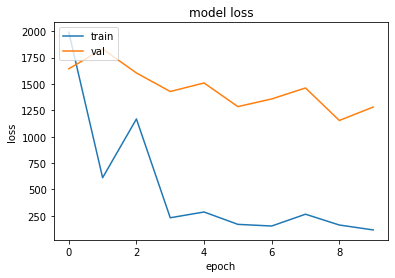

In [47]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

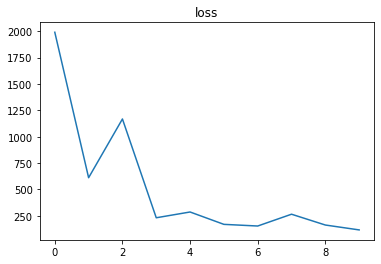

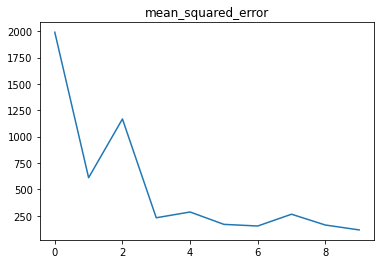

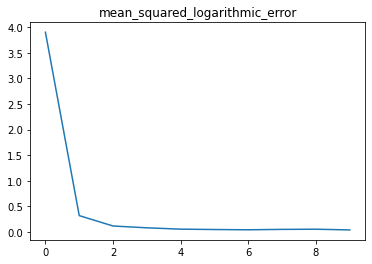

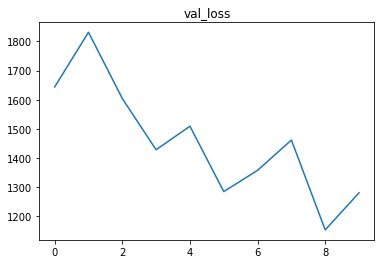

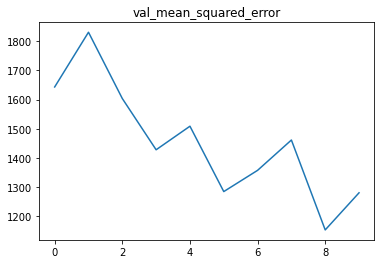

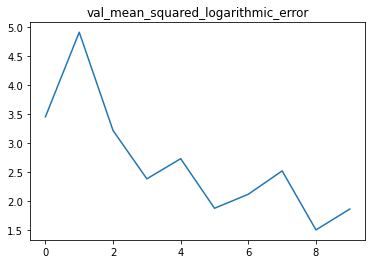

In [48]:
for k, hist in history.history.items():
  plt.plot(hist)
  plt.title(k)
  plt.show()